In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
df = pd.read_csv("Historical_data.csv", parse_dates=["Date"], index_col="Date", dtype=str)
df.replace({r"[\$,]": ""}, regex=True, inplace=True)
df = df.astype("float64")
df = df.sort_index(ascending=True)
log_returns = np.log(df / df.shift(1)).dropna()
mean_returns = log_returns.mean() * 252
cov_matrix = log_returns.cov() * 252
returns = df.pct_change().dropna()

In [6]:
n_years = (df.index[0] - df.index[-1]).days / 365.25
cagr = (df.iloc[0] / df.iloc[-1]) ** (1 / n_years) - 1

print("CAGR (Compounded Annual Growth Rate):\n", cagr)

CAGR (Compounded Annual Growth Rate):
 AAPL     0.199495
AMZN     0.107769
GOOGL    0.186384
MSFT     0.200532
TSLA     0.422725
NVDA     0.734397
META     0.238766
dtype: float64


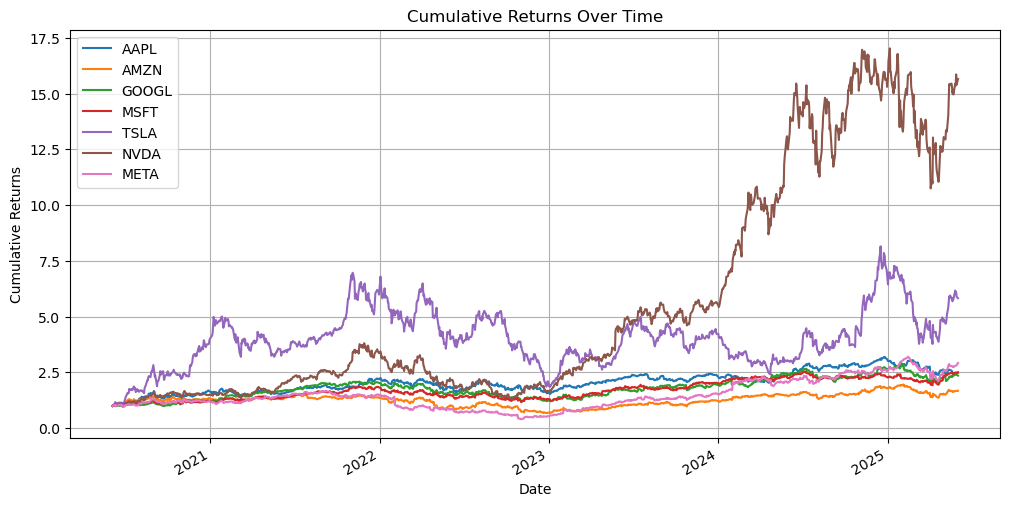

In [7]:
# Plot the cumulative returns
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(12, 6))
plt.title("Cumulative Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [8]:
# Portfolio metrics
def portfolio_perf(weights):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = ret / vol
    return ret, vol, sharpe

In [9]:
# Maximize Sharpe
def neg_sharpe(weights):
    return -portfolio_perf(weights)[2]

In [10]:
n = len(mean_returns)
bounds = [(0, 1)] * n
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
init_guess = np.ones(n) / n

In [11]:
opt_result = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_result.x
opt_ret, opt_vol, opt_sharpe = portfolio_perf(opt_weights)

In [12]:
# Efficient frontier
target_rets = np.linspace(mean_returns.min(), mean_returns.max(), 100)
frontier_vols = []

for tr in target_rets:
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w, tr=tr: np.dot(w, mean_returns) - tr}
    )
    res = minimize(lambda w: np.sqrt(w.T @ cov_matrix @ w), init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_vols.append(res.fun if res.success else np.nan)

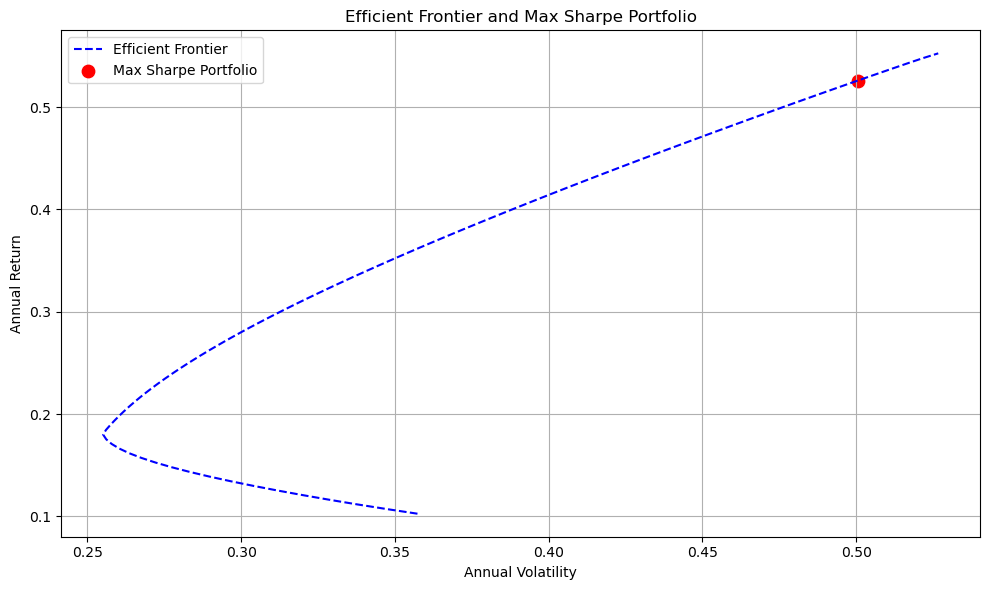

In [13]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(frontier_vols, target_rets, 'b--', label='Efficient Frontier')
plt.scatter(opt_vol, opt_ret, c='r', s=80, label='Max Sharpe Portfolio')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Efficient Frontier and Max Sharpe Portfolio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Save the optimal weights to a CSV file
weights_series = pd.Series(opt_weights, index=df.columns, name='weight')
# Save to CSV
weights_series.to_csv('max_sharpe_weights.csv', header=True)
# Save the efficient frontier data to a CSV file
target_rets = np.array(target_rets)
frontier_vols = np.array(frontier_vols)
frontier_df = pd.DataFrame({
    'return': target_rets,
    'risk': frontier_vols
})
frontier_df['sharpe'] = frontier_df['return'] / frontier_df['risk']  # optional
frontier_df.to_csv('efficient_frontier.csv', index=False)

In [23]:
# Save the optimal weights to a CSV file
portfolio_returns = returns @ opt_weights
cumulative_returns = (1 + portfolio_returns).cumprod()
cumulative_returns.name = 'Cumulative Returns'
cumulative_returns.index.name = 'Date'
cumulative_returns_df = pd.DataFrame({
    'cumulative_return': cumulative_returns
}, index=returns.index)

cumulative_returns_df.to_csv('max_sharpe_cum_returns.csv')

In [19]:
# Print results
print("Maximum Sharpe Portfolio Weights:")
for name, weight in zip(df.columns, opt_weights):
    print(f"{name}: {weight:.4f}")
print(f"\nExpected Annual Return: {opt_ret:.4f}")
print(f"Expected Annual Volatility: {opt_vol:.4f}")
print(f"Sharpe Ratio: {opt_sharpe:.4f}")

Maximum Sharpe Portfolio Weights:
AAPL: 0.0512
AMZN: 0.0000
GOOGL: 0.0000
MSFT: 0.0000
TSLA: 0.0384
NVDA: 0.9103
META: 0.0000

Expected Annual Return: 0.5259
Expected Annual Volatility: 0.5005
Sharpe Ratio: 1.0507
